<a href="https://colab.research.google.com/github/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics/blob/master/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
! rm -rf Machine-Learning-in-Atmospheric-Thermodynamics
! git clone https://github.com/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics.git

Cloning into 'Machine-Learning-in-Atmospheric-Thermodynamics'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 703 (delta 135), reused 242 (delta 118), pack-reused 430
Receiving objects: 100% (703/703), 249.42 MiB | 46.93 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from sklearn.model_selection import train_test_split

path='Machine-Learning-in-Atmospheric-Thermodynamics/final/'
filen=path+'/data/inver_data.dat'

nz=101
nvar=3
data=np.fromfile(filen,dtype=np.float32)
data=data.reshape(-1,2,nvar,nz)
inv=np.argmax(np.copy(data[:,:,2,0:99]).reshape(-1,1,nz-2),2)
y=np.where(inv<=0,0,1)
x=np.copy(data[:,:,0:2,0:int(nz/2)]).reshape(-1,nvar-1,int(nz/2))

print(x.shape,y.shape)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

label_unique, counts=np.unique(y_train,return_counts=True)
print(label_unique, counts)
weight=[sum(counts)/c for c in counts]
print(weight)

scaler=[]
scaler.append(MinMaxScaler())
scaler.append(MinMaxScaler())

for i in range(0,2):
  x_train[:,i,:]=scaler[i].fit_transform(x_train[:,i,:])
  x_test[:,i,:]=scaler[i].transform(x_test[:,i,:])

x_train=x_train.reshape(-1,int(nz/2)*2)
x_test=x_test.reshape(-1,int(nz/2)*2)

print('finished')

(18834, 2, 50) (18834, 1)
[0 1] [11812  3255]
[1.2755672197764985, 4.628878648233487]
finished


In [72]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class TrainData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)

train_data=TrainData(torch.FloatTensor(x_train),torch.FloatTensor(y_train))
test_data=TrainData(torch.FloatTensor(x_test),torch.FloatTensor(y_test))

BATCH_SIZE=64
weight_train=[weight[k] for k in y_train.reshape(-1).astype(int)]
sampler_train=WeightedRandomSampler(weight_train,len(y_train))
train_loader=DataLoader(dataset=train_data,sampler=sampler_train,batch_size=BATCH_SIZE)

weight_test=[weight[k] for k in y_test.reshape(-1).astype(int)]
sampler_test=WeightedRandomSampler(weight_test,len(y_test))
test_loader=DataLoader(dataset=test_data,sampler=sampler_test,batch_size=BATCH_SIZE)


print('finished')

finished


In [73]:
from torch import nn
from torchvision.transforms import ToTensor, Lambda, Compose
import time

class BinaryClassification(nn.Module):
  def __init__(self):
    super(BinaryClassification, self).__init__()
    self.BC = nn.Sequential(
      nn.Linear(100, 256),   
      nn.ReLU(),     
      nn.BatchNorm1d(256),   
      nn.Linear(256, 192),
      nn.ReLU(),
      nn.BatchNorm1d(192),
      nn.Dropout(p=0.1),
      nn.Linear(192, 1)
    )

  def forward(self, x):
    freq = self.BC(x)
    binary = freq #torch.round(freq)
    return binary

print('defined model')

defined model


In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BinaryClassification().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    train_loss=0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)  
        loss = loss_fn(pred, y) 
        train_loss += loss.item()

        optimizer.zero_grad()  
        loss.backward()      
        optimizer.step()      
       
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(torch.sigmoid(pred))==y).sum().float()

    test_loss /= num_batches
    correct /= size
    correct = correct.to("cpu")
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss,correct

# training start
epochs=50

tt=time.time()
train_loss=[]
test_loss=[]
test_acc=[]
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss,acc = test(test_loader, model, loss_fn)
    test_loss.append(loss)
    test_acc.append(acc*100.)

elapse=time.time()-tt
print(elapse)

torch.save(model.state_dict(),'model.pkl')

Epoch 1-------------------------------
Accuracy: 76.8%, Avg loss: 0.542662
Epoch 2-------------------------------
Accuracy: 78.3%, Avg loss: 0.507202
Epoch 3-------------------------------
Accuracy: 82.1%, Avg loss: 0.468204
Epoch 4-------------------------------
Accuracy: 81.6%, Avg loss: 0.445480
Epoch 5-------------------------------
Accuracy: 83.9%, Avg loss: 0.430649
Epoch 6-------------------------------
Accuracy: 83.3%, Avg loss: 0.417396
Epoch 7-------------------------------
Accuracy: 84.3%, Avg loss: 0.397357
Epoch 8-------------------------------
Accuracy: 84.5%, Avg loss: 0.389200
Epoch 9-------------------------------
Accuracy: 84.4%, Avg loss: 0.373162
Epoch 10-------------------------------
Accuracy: 84.0%, Avg loss: 0.374713
Epoch 11-------------------------------
Accuracy: 85.0%, Avg loss: 0.368957
Epoch 12-------------------------------
Accuracy: 86.1%, Avg loss: 0.351013
Epoch 13-------------------------------
Accuracy: 86.0%, Avg loss: 0.342456
Epoch 14-------------

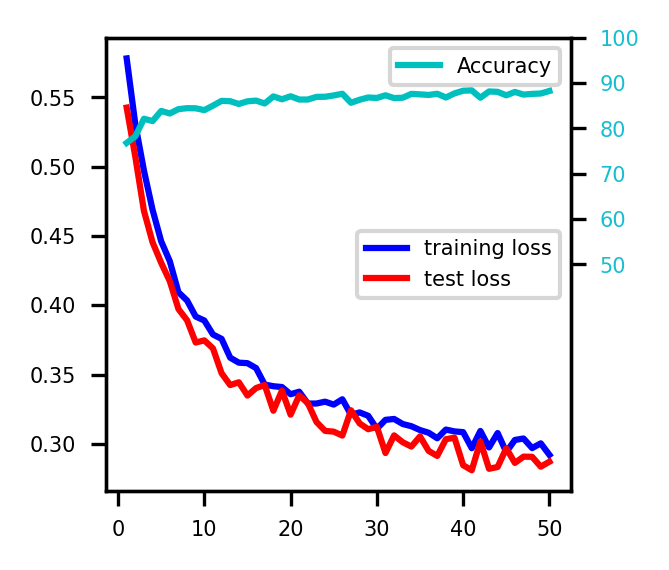

In [75]:
fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(np.arange(1,epochs+1),train_loss,'b',np.arange(1,epochs+1),test_loss,'r')
ax.tick_params(labelsize=5)
plt.legend(["training loss","test loss"],fontsize=5,loc=7)
ax2=ax.twinx()
ax2.plot(np.arange(1,epochs+1),test_acc,'c')
ax2.set_ylim([0,100])
ax2.set_yticks(np.arange(50,101,10))
color='tab:cyan'
ax2.tick_params(axis='y',labelcolor=color,labelsize=5)
plt.legend(["Accuracy"],fontsize=5,loc=1)





Accuracy is  0.8744358906291478
Precision is  0.8881036513545347
Recall is  0.666077738515901
F1 score is  0.7612317011610298



3767


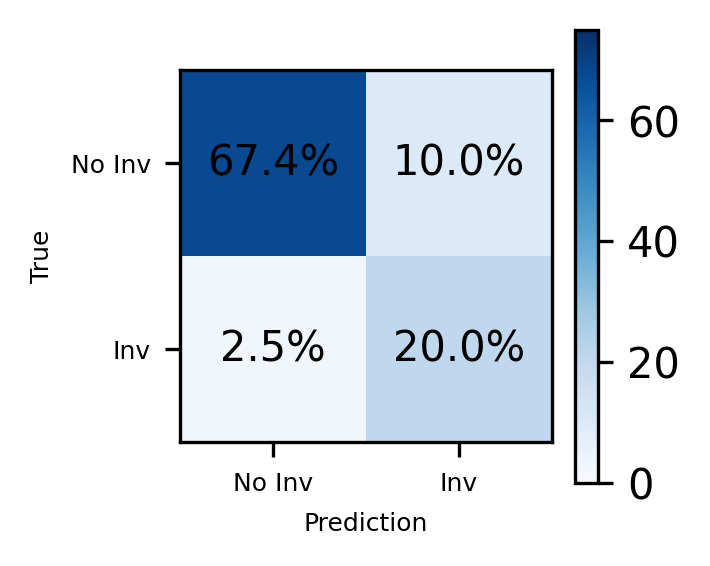

In [123]:
model2 = BinaryClassification()
model2.load_state_dict(torch.load('model.pkl'))
model2.eval()

classes=["No Inv","Inv"]

test_loader=DataLoader(dataset=test_data,batch_size=1)

cm=np.zeros([2,2])
a=0
for x,y in test_loader:
  pred = model2(x)
  pred = torch.round(torch.sigmoid(pred))
  x1=pred.detach().numpy().astype(int)
  y1=y.detach().numpy().astype(int)
  cm[y1,x1]+=1
  a+=1

print('\n\n')
print('Accuracy is ',np.diagonal(cm).sum()/cm.sum())
print('Precision is ',cm[1,1]/cm[1,:].sum())
print('Recall is ',cm[1,1]/cm[:,1].sum())
print('F1 score is ',2.*(cm[1,1]/cm[:,1].sum()*cm[1,1]/cm[1,:].sum())/(cm[1,1]/cm[:,1].sum()+cm[1,1]/cm[1,:].sum()))
print('\n\n')

print(a)
cm=cm/a*100

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(2,2),dpi=300)

im=ax.imshow(cm,cmap='Blues',vmin=0,vmax=75)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Prediction',fontsize=6)
ax.set_ylabel('True',fontsize=6)
ax.tick_params(labelsize=6)
fig.colorbar(im)

cm=0.1*((10.*cm).astype(int))
for i in range(len(classes)):
  for j in range(len(classes)):
    text = ax.text(j,i,str(cm[i,j])+"%",ha="center",va="center",color="k")




torch.Size([3767, 100]) torch.Size([3767, 1])
0.9502543410745699


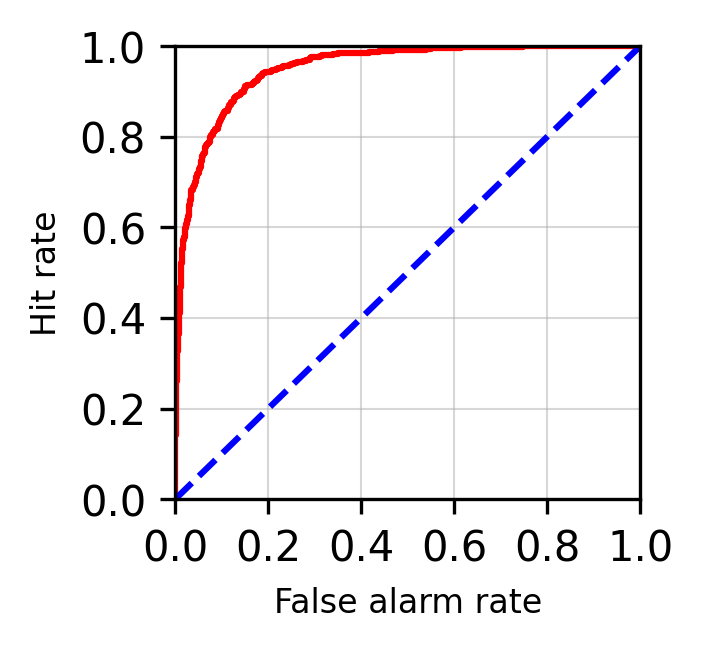

In [124]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

valid_loader=DataLoader(dataset=test_data,batch_size=len(test_data))
for x,y in valid_loader:
  print(x.shape,y.shape)
  pred = model2(x)
  pred = torch.sigmoid(pred)
  x1=pred.detach().numpy()
  y1=y.detach().numpy()

rocx,rocy,_=roc_curve(y1,x1)
roc_area=roc_auc_score(y1,x1)
print(roc_area)

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(rocx,rocy,'r-',[0, 1],[0, 1],'b--')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.1,0.2))
ax.set_yticks(np.arange(0,1.1,0.2))
ax.set_xlabel('False alarm rate',fontsize=8)
ax.set_ylabel('Hit rate',fontsize=8)
ax.grid(lw=0.5,alpha=0.5)
     